## Model topology 03: inverting geomodel using topology

After inspecting model topologies in the previous notebooks, we now go to the inversion step.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

# import gempy here if in system - added local import below
# import gempy as gp
from gempy.assets import topology as tp

In [2]:
import sys
sys.path.append('../gempy/')
import gempy as gp
from gempy.assets import topology as tp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Initial gempy model

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                        values
range             1732.050808
$C_o$            71428.571429
drift equations     [3, 3, 3]


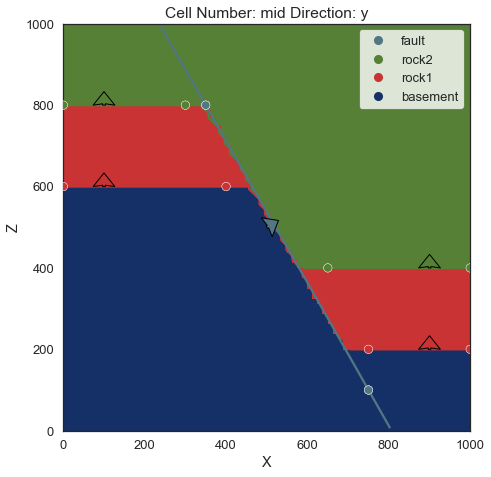

In [24]:
geo_model = gp.create_model('topology_example')
geo_model = gp.init_data(geo_model, extent = [0, 1000, 0, 1000, 0, 1000], resolution = [80,80,80],
                        path_o = 'or_prior_simpler.csv',
                        path_i = 'surf_prior_simpler_2.csv')

gp.map_stack_to_surfaces(geo_model, 
                        {'fault' : ['fault'],
                        'layers' : ['rock1', 'rock2']})

geo_model.set_is_fault(['fault'])

geo_model.surfaces.colors.change_colors({'rock1': '#ca3333',
                                        'rock2' : '#558035',
                                        'basement' : '#153066'})

interp_data = gp.set_interpolator(geo_model,
                                 compile_theano=True,
                                 theano_optimizer='fast_run', gradient=False,
                                 dype='float32')
gp.compute_model(geo_model)

gp.plot_2d(geo_model, direction='y')

### Topology of initial model

In [4]:
edges_ori, centroids_ori = tp.compute_topology(geo_model)

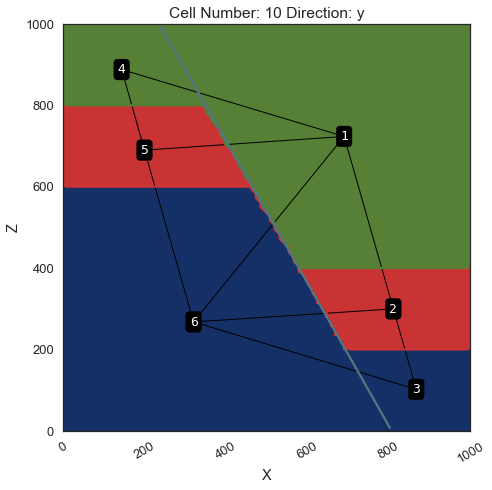

In [5]:
gp.plot_2d(geo_model, show_data = False, direction = 'y', cell_number = 10)
gp.plot.plot_topology(geo_model, edges_ori, centroids_ori, scale=True)
plt.show()

## Inversion with rejection sampling



In [25]:
# same function as before to modify geomodel

def modify_geomodel(rock1_left=600, rock1_right=200, rock2_left=800, rock2_right=400, \
    fault_bottom_x=750, fault_top_x=350):
    """Modify and compute geological model for given surface positions
    
    In this highly simplified update function, we only adjust the vertical (z)-position of the surfaces
    and the x-position of the fault points.
    """

    # modifly surface points in vertical direction
    geo_model.modify_surface_points([6,7,8,9], Z=4*[rock1_left])
    geo_model.modify_surface_points([10,11,12,13], Z=4*[rock1_right])
    geo_model.modify_surface_points([14,15,16,17], Z=4*[rock2_left])
    geo_model.modify_surface_points([18,19,20,21], Z=4*[rock2_right])

    # modify fault points in x-direction:
    geo_model.modify_surface_points([0,2,4], X=3*[fault_bottom_x])
    geo_model.modify_surface_points([1,3,5], X=3*[fault_top_x])

    # modify fault orientation value:
    # delete fault orientation
    geo_model.delete_orientations([4])
    # obtain new value from three points
    gp.set_orientation_from_surface_points(geo_model, [0, 1, 2])

    geo_model.update_to_interpolator()

    # compute model
    gp.compute_model(geo_model)
    # gp.plot_2d(geo_model, show_data = False, direction = 'y', cell_number = 10)

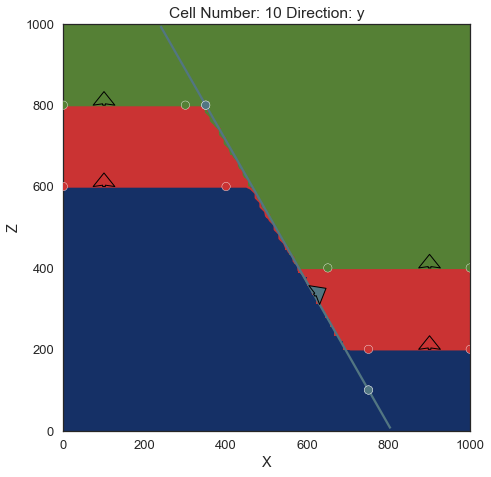

In [7]:
modify_geomodel()
gp.plot_2d(geo_model, show_data = True, direction = 'y', cell_number = 10, legend=False)


### Initialize random vars

In [26]:
# set standard derivation as same for all
point_std = 70

# surface points, vertical position
rock1_left_dist = norm(600, point_std)
rock1_right_dist = norm(200, point_std)
rock2_left_dist = norm(800, point_std)
rock2_right_dist = norm(400, point_std)

# fault points, lateral/ x-position:
fault_top_dist = norm(350, point_std)
fault_bottom_dist = norm(750, point_std)

### Perform sampling

### No rejection

In [27]:
n_iterations = 500

# store number of sims for check
n_sims = 0

for i in tqdm(range(n_iterations)):
    
        # sample parameters
    rock1_left = rock1_left_dist.rvs()
    rock1_right = rock1_right_dist.rvs()
    rock2_left = rock2_left_dist.rvs()
    rock2_right = rock2_right_dist.rvs()
    fault_top_x = fault_top_dist.rvs()
    fault_bottom_x = fault_bottom_dist.rvs()
    # update and compute model
    try:
        modify_geomodel(rock1_left=rock1_left,
                        rock1_right=rock1_right,
                        rock2_left=rock2_left,
                        rock2_right=rock2_right,
                        fault_top_x=fault_top_x,
                        fault_bottom_x=fault_bottom_x) 
    except ValueError: 
        # add deleted orientation again
        geo_model.modify_surface_points([1,3,5], X=3*[350])
        geo_model.modify_surface_points([0,2,4], X=3*[750])
        gp.set_orientation_from_surface_points(geo_model, [0, 1, 2])
        continue

            
    np.save('lith_blocks_pr/block_1_%0 4d.npy'%i, geo_model.solutions.lith_block)
    np.save('fault_blocks_pr/fblock_1_%04d.npy'%i, geo_model.solutions.fault_block)
  
    n_sims += 1
        

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [57:10<00:00,  6.86s/it]


## Rejection

In [7]:
n_iterations = 500
epsilon = 0.02
centroid_cutoff = 20
#thickness_cutoff = 400
thick_diff_cutoff = 100

# lists to store results (length not known for rejected)
accepted = []
rejected = []

# store number of sims for check
n_sims = 0

for i in tqdm(range(n_iterations)):

    distance = epsilon + 1
    cent_diff = centroid_cutoff + 1
    #thick_left = thickness_cutoff + 1
    #thick_right = thickness_cutoff + 1
    thick_diff = thick_diff_cutoff + 1
    
    while distance > epsilon or cent_diff > centroid_cutoff or thick_diff > thick_diff_cutoff:

        # sample parameters
        rock1_left = rock1_left_dist.rvs()
        rock1_right = rock1_right_dist.rvs()
        rock2_left = rock2_left_dist.rvs()
        rock2_right = rock2_right_dist.rvs()
        fault_top_x = fault_top_dist.rvs()
        fault_bottom_x = fault_bottom_dist.rvs()

        # update and compute model
        try:
            modify_geomodel(rock1_left=rock1_left,
                            rock1_right=rock1_right,
                            rock2_left=rock2_left,
                            rock2_right=rock2_right,
                            fault_top_x=fault_top_x,
                            fault_bottom_x=fault_bottom_x) 
        except ValueError: 
            # add deleted orientation again
            geo_model.modify_surface_points([1,3,5], X=3*[350])
            geo_model.modify_surface_points([0,2,4], X=3*[750])
            gp.set_orientation_from_surface_points(geo_model, [0, 1, 2])
            continue

        # calculate topology difference
        edges, centroids = tp.compute_topology(geo_model)
        
        cent_diff = 0 
        if len(centroids) == len(centroids_ori):
            for k in range(0,5):
                cent_diff += np.sqrt(np.sum((list(centroids_ori.values())[k] - list(centroids.values())[k])**2))
        else:
            cent_diff = 100
        
        #reject models where the thickness is nonsense
        thick_left = abs(rock1_left - rock2_left)
        thick_right = abs(rock1_right - rock2_right)
        thick_diff = abs(thick_left - thick_right)
     
        # compute jaccard index
        j = tp.jaccard_index(edges_ori, edges)

        distance = 1 - j
        if distance <= epsilon and cent_diff < centroid_cutoff and thick_diff < thick_diff_cutoff: # accept
            accepted.append({'rock1_left' : rock1_left, 'rock1_right' : rock1_right,
                             'rock2_left' : rock2_left, 'rock2_right' : rock2_right,
                             'fault_top_x' : fault_top_x, 'fault_bottom_x' : fault_bottom_x})
            
            np.save('lith_blocks/block_1_%04d.npy'%i, geo_model.solutions.lith_block)
            np.save('fault_blocks/fblock_1_%04d.npy'%i, geo_model.solutions.fault_block)

        else: # also keep rejected samples
            rejected.append({'rock1_left' : rock1_left, 'rock1_right' : rock1_right,
                             'rock2_left' : rock2_left, 'rock2_right' : rock2_right,
                             'fault_top_x' : fault_top_x, 'fault_bottom_x' : fault_bottom_x})        
        n_sims += 1
        

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [5:09:45<00:00, 37.17s/it]


In [8]:
n_sims

2464

In [9]:
len(accepted), len(rejected)

(500, 1964)

In [10]:
acc_rate = len(accepted) / (len(accepted) + len(rejected))
print("Acceptance rate: %.3f" % acc_rate)

Acceptance rate: 0.203


### Analyse posterior

In [11]:
# re-sort dictionaries
rock1_left_acc = np.empty(len(accepted))
rock1_right_acc = np.empty(len(accepted))
rock2_left_acc = np.empty(len(accepted))
rock2_right_acc = np.empty(len(accepted))
fault_top_x_acc = np.empty(len(accepted))
fault_bottom_x_acc = np.empty(len(accepted))

for i,acc_dict in enumerate(accepted):
    rock1_left_acc[i] = acc_dict['rock1_left']
    rock1_right_acc[i] = acc_dict['rock1_right']
    rock2_left_acc[i] = acc_dict['rock2_left']
    rock2_right_acc[i] = acc_dict['rock2_right']
    fault_top_x_acc[i] = acc_dict['fault_top_x']
    fault_bottom_x_acc[i] = acc_dict['fault_bottom_x']


    

In [12]:
param_names = ['rock1_left_acc', 'rock1_right_acc', 'rock2_left_acc', 'rock2_right_acc',
              'fault_top_x_acc', 'fault_bottom_x_acc']

In [85]:
acc_stds = [80.45654435589891,82.44399382128356,94.33379935253285,74.51034642169633,69.34481994893596,58.567177985361454]
acc_means = [576.7849218054341, 191.43050342194923, 807.6992761082684, 418.3102204161038,695.5420380189431,393.42859675660856]

Text(0, 0.5, 'fault')

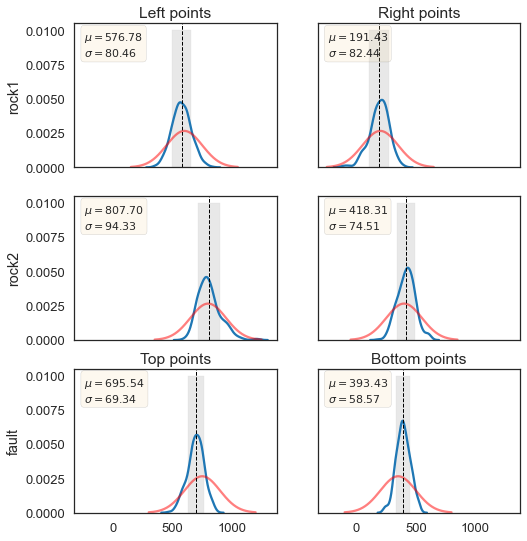

In [89]:
n_bins = 50
nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows, ncols, sharex = True, sharey = True, figsize = (4*ncols, 3*nrows))

xvals = np.arange(rock1_left_dist.mean()-3*point_std, rock1_left_dist.mean()+3*point_std)
#axes[0,0].hist(rock1_left_acc, bins=n_bins, density=True)
sns.distplot(rock1_left_acc, kde = True, hist = False, ax = axes[0,0])
axes[0,0].plot(xvals, rock1_left_dist.pdf(xvals), alpha = 0.5, color = 'red')

xvals = np.arange(rock1_right_dist.mean()-3*point_std, rock1_right_dist.mean()+3*point_std)
#axes[0,1].hist(rock1_right_acc, bins=n_bins, density=True)
sns.distplot(rock1_right_acc, kde = True, hist = False, ax = axes[0,1])
axes[0,1].plot(xvals, rock1_right_dist.pdf(xvals), alpha = 0.5, color = 'red')

xvals = np.arange(rock2_left_dist.mean()-3*point_std, rock2_left_dist.mean()+3*point_std)
#axes[1,0].hist(rock2_left_acc, bins=n_bins, density=True)
sns.distplot(rock2_left_acc, kde = True, hist = False, ax = axes[1,0])
axes[1,0].plot(xvals, rock2_left_dist.pdf(xvals), alpha = 0.5, color = 'red')

xvals = np.arange(rock2_right_dist.mean()-3*point_std, rock2_right_dist.mean()+3*point_std)
#axes[1,1].hist(rock2_right_acc, bins=n_bins, density=True)
sns.distplot(rock2_right_acc, kde = True, hist = False, ax = axes[1,1])
axes[1,1].plot(xvals, rock2_right_dist.pdf(xvals), alpha = 0.5, color = 'red')

xvals = np.arange(fault_bottom_dist.mean()-3*point_std, fault_bottom_dist.mean()+3*point_std)
#axes[2,0].hist(fault_bottom_x_acc, bins=n_bins, density=True)
sns.distplot(fault_bottom_x_acc, kde = True, hist = False, ax = axes[2,0])
axes[2,0].plot(xvals, fault_bottom_dist.pdf(xvals), alpha = 0.5, color = 'red')

xvals = np.arange(fault_top_dist.mean()-3*point_std, fault_top_dist.mean()+3*point_std)
#axes[2,1].hist(fault_top_x_acc, bins=n_bins, density=True)
sns.distplot(fault_top_x_acc, kde = True, hist = False, ax = axes[2,1])
axes[2,1].plot(xvals, fault_top_dist.pdf(xvals), alpha = 0.5, color = 'red')

for i, ax in enumerate(fig.axes):
    ax.axvline(acc_means[i], color = 'k', linestyle = 'dashed', linewidth = 1)
    ax.fill_betweenx([0,0.01], acc_means[i] - acc_stds[i], acc_means[i] + acc_stds[i], color = 'lightgrey', alpha = 0.5)

    textstr = '\n'.join((
            r'$\mu=%.2f$' % (acc_means[i], ),
            r'$\sigma=%.2f$' % (acc_stds[i], )))
    props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.2)
    ax.text(0.05,0.95, textstr, transform = ax.transAxes, fontsize = 11, 
           verticalalignment = 'top', bbox = props)

axes[0,0].set_title('Left points')
axes[0,1].set_title('Right points')
axes[2,0].set_title('Top points')
axes[2,1].set_title('Bottom points')
axes[0,0].set_ylabel('rock1')
axes[1,0].set_ylabel('rock2')
axes[2,0].set_ylabel('fault')

In [3]:
import pickle
pickle.dump(accepted, open("accepted_dict.pkl", 'wb'))

NameError: name 'accepted' is not defined

In [14]:
pickle.dump(rejected, open("rejected_dict.pkl", 'wb'))

Combine into pandas df for more analyses

In [15]:
all_post = np.array([rock1_left_acc, rock1_right_acc, rock2_left_acc, rock2_right_acc,
fault_bottom_x_acc, fault_top_x_acc])


df = pd.DataFrame(all_post.transpose(), columns = ['r1_l','r1_r','r2_l', 'r2_r', 'fb', 'ft'])

In [16]:
df.to_csv(r'accepted_500_hd.csv')

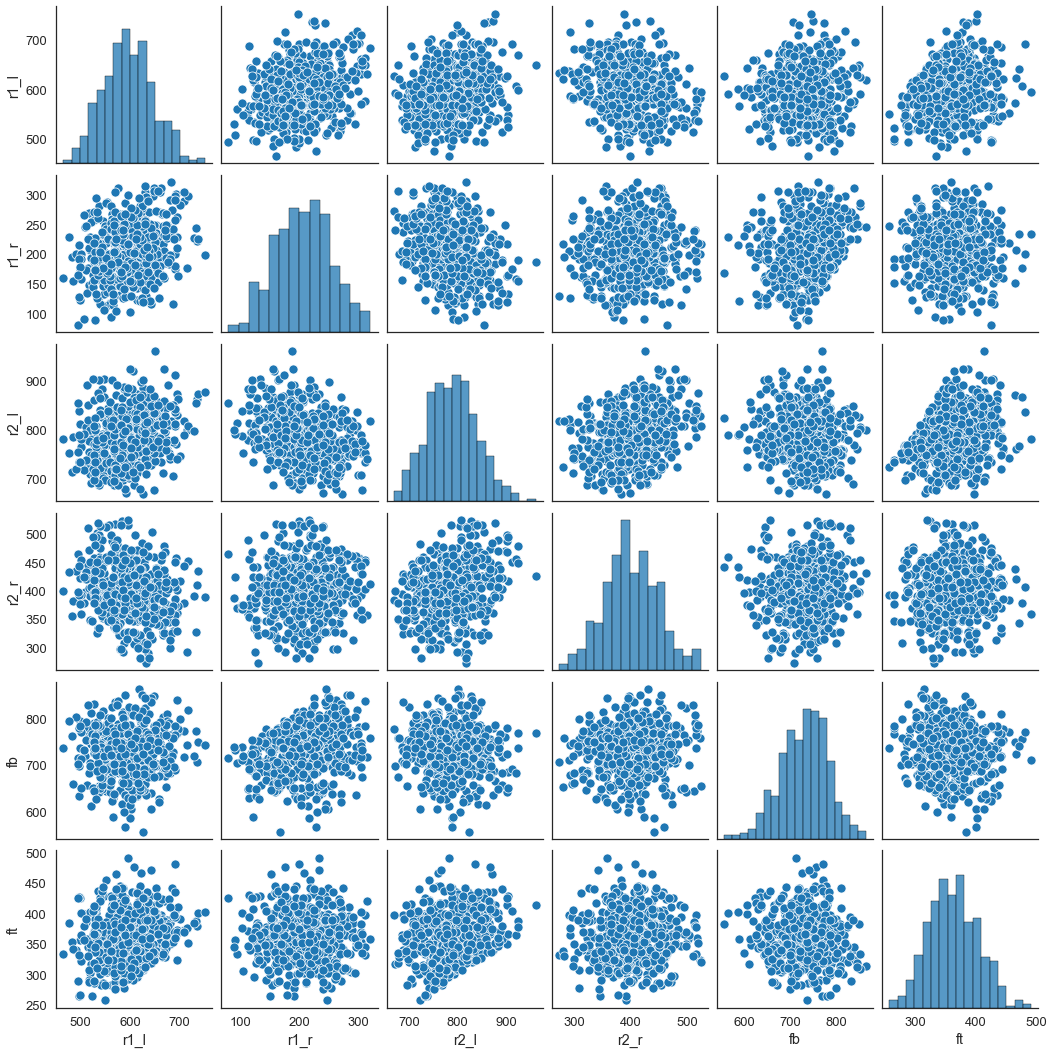

In [18]:
sns.pairplot(df)

## Comparing accepted and rejected models

In [6]:
import pickle
f = open('accepted_dict.pkl', 'rb')
accepted = pickle.load(f)

EOFError: Ran out of input

In [21]:
def plot_realizations(dictionary, n=16):
    """Create n random realisations and create overview plot
    
    n should be multiple of 4
    """

    fig, ax = plt.subplots(n//4, 4, figsize=(12,12))

    # draw random idx
    idx_array = np.random.choice(np.arange(len(dictionary)), 16, replace=False)
    

    for i, idx in enumerate(idx_array):
        # generate model
        modify_geomodel(rock1_left=dictionary[idx]["rock1_left"],
                rock1_right=dictionary[idx]["rock1_right"],
                rock2_left=dictionary[idx]["rock2_left"],
                rock2_right=dictionary[idx]["rock2_right"],
                fault_top_x=dictionary[idx]["fault_top_x"],
                fault_bottom_x=dictionary[idx]["fault_bottom_x"])
        
        # extract gempy geology blocks
        tmp = geo_model.solutions.block_matrix[1,0,:].reshape(80,80,80)


        ax[i//4, i%4].imshow(tmp[:,0,::-1].transpose(), 'tab20c')

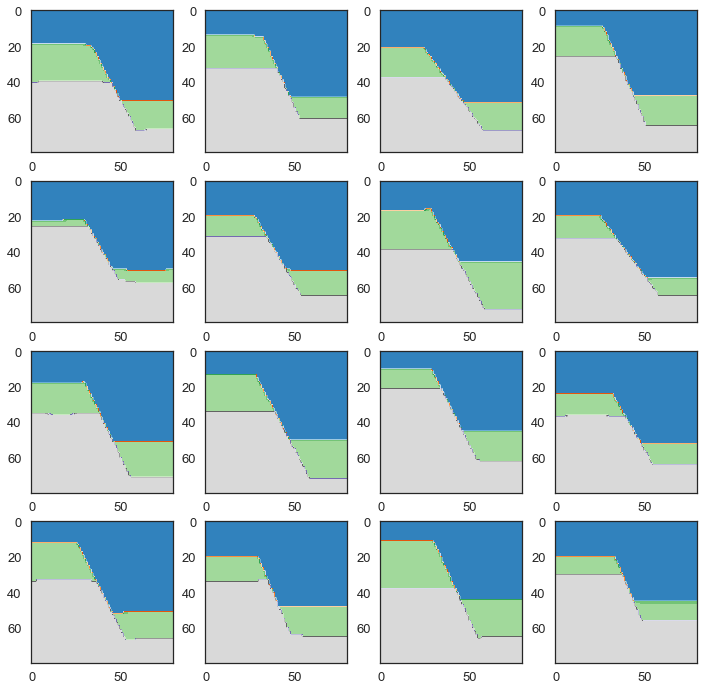

In [22]:
plot_realizations(accepted)

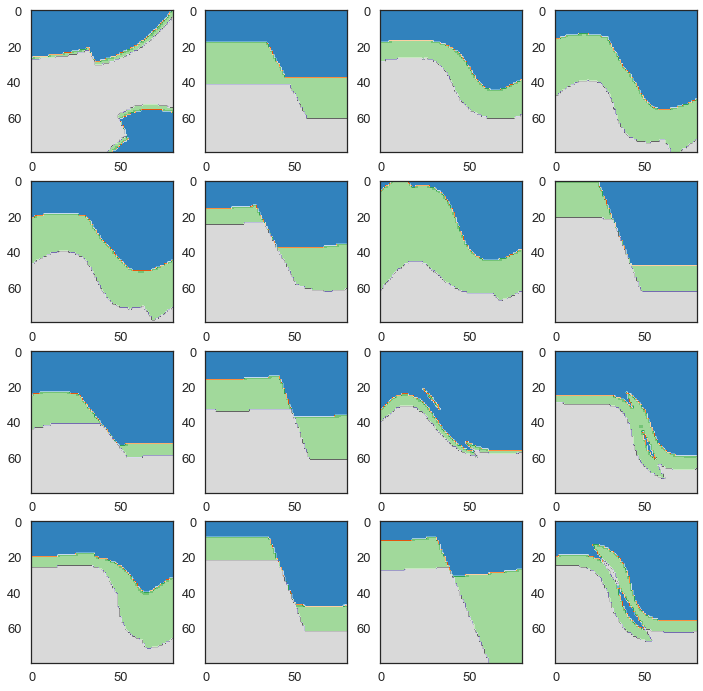

In [23]:
plot_realizations(rejected)